In [ ]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2026.zip
!unzip project2026.zip
!ls -l

!git clone https://github.com/ArturoBenedettiMichelangeli/GO_Neural_Network.git

Archive:  project2026.zip
  inflating: games.data              
  inflating: golois.cpython-312-x86_64-linux-gnu.so  
total 665404
-rw-r--r-- 1 root root 542497580 Oct  7  2022 games.data
-rwxr-xr-x 1 root root    284672 Oct  1 15:09 golois.cpython-312-x86_64-linux-gnu.so
-rw-r--r-- 1 root root 138578548 Feb 22 12:46 project2026.zip
drwxr-xr-x 1 root root      4096 Feb  6 14:31 sample_data


In [31]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers, regularizers, losses, metrics
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import gc
import matplotlib.pyplot as plt
from pathlib import Path
import json
import golois

In [9]:
model_dir = Path() / "models"
histo_dir = Path() / "history"
figures_dir = Path() / "figures"

model_dir.mkdir(parents=True, exist_ok=True)
histo_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

##Architectures/techniques testées :

* reseaux residuels (resnet)
* reseaux residuels + attention en sortie (SE-post-block)
* meme chose + cosine annealing
* avec/sans distillation
* Réseau MobileNet avec CosineAnnealing et Swish Activation dans le bloc résiduel

###ResNet

In [11]:
# ===================== #
# ARCHITECTURE          #
# ===================== #
def create_resnet_for_go_model(planes, filters, num_blocks, name="ResNetGO"):
  """Création d'un modèle résiduel à deux têtes : une pour la politique et une pour la valeur"""
  # --- Input ---
  input_layer = keras.Input(shape=(19, 19, planes), name='board')

  # --- Conv. ---
  x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input_layer)

  # --- Residual Block ---
  for i in range(num_blocks):
      ident = x
      x = layers.Conv2D(filters, 3, padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.Conv2D(filters, 3, padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.add([ident, x])
      x = layers.ReLU()(x)

  # --- Policy head ---
  policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(x)
  policy_head = layers.Flatten()(policy_head)
  policy_head = layers.Activation('softmax', name='policy')(policy_head)

  # --- Value Head ---
  value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(x)
  value_head = layers.Flatten()(value_head)
  value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
  value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

  return keras.Model(inputs=input_layer, outputs=[policy_head, value_head], name=name)


Chargement du set de validation séparé...
Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 6.2758 - policy_categorical_accuracy: 0.0045 - policy_loss: 6.1350 - value_loss: 0.1314 - value_mae: 0.3036
[5.982040882110596, 5.853459358215332, 0.11933179944753647, 0.006000000052154064, 0.29232823848724365]
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.9660 - policy_categorical_accuracy: 0.0080 - policy_loss: 5.8335 - value_loss: 0.1233 - value_mae: 0.2938
[5.902416229248047, 5.773793697357178, 0.11928239464759827, 0.01549999974668026, 0.29221341013908386]
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.8172 - policy_categorical_accuracy: 0.0155 - policy_loss: 5.6848 - value_loss: 0.1232 - value_mae: 0.2967
[5.748227596282959, 5.619986534118652, 0.11901982873678207, 0.02449999935925007, 0.292046457529068]
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.5850 - policy_categorical_accuracy: 0.0285 - policy_loss: 5.4534 - value_loss: 0.1227 

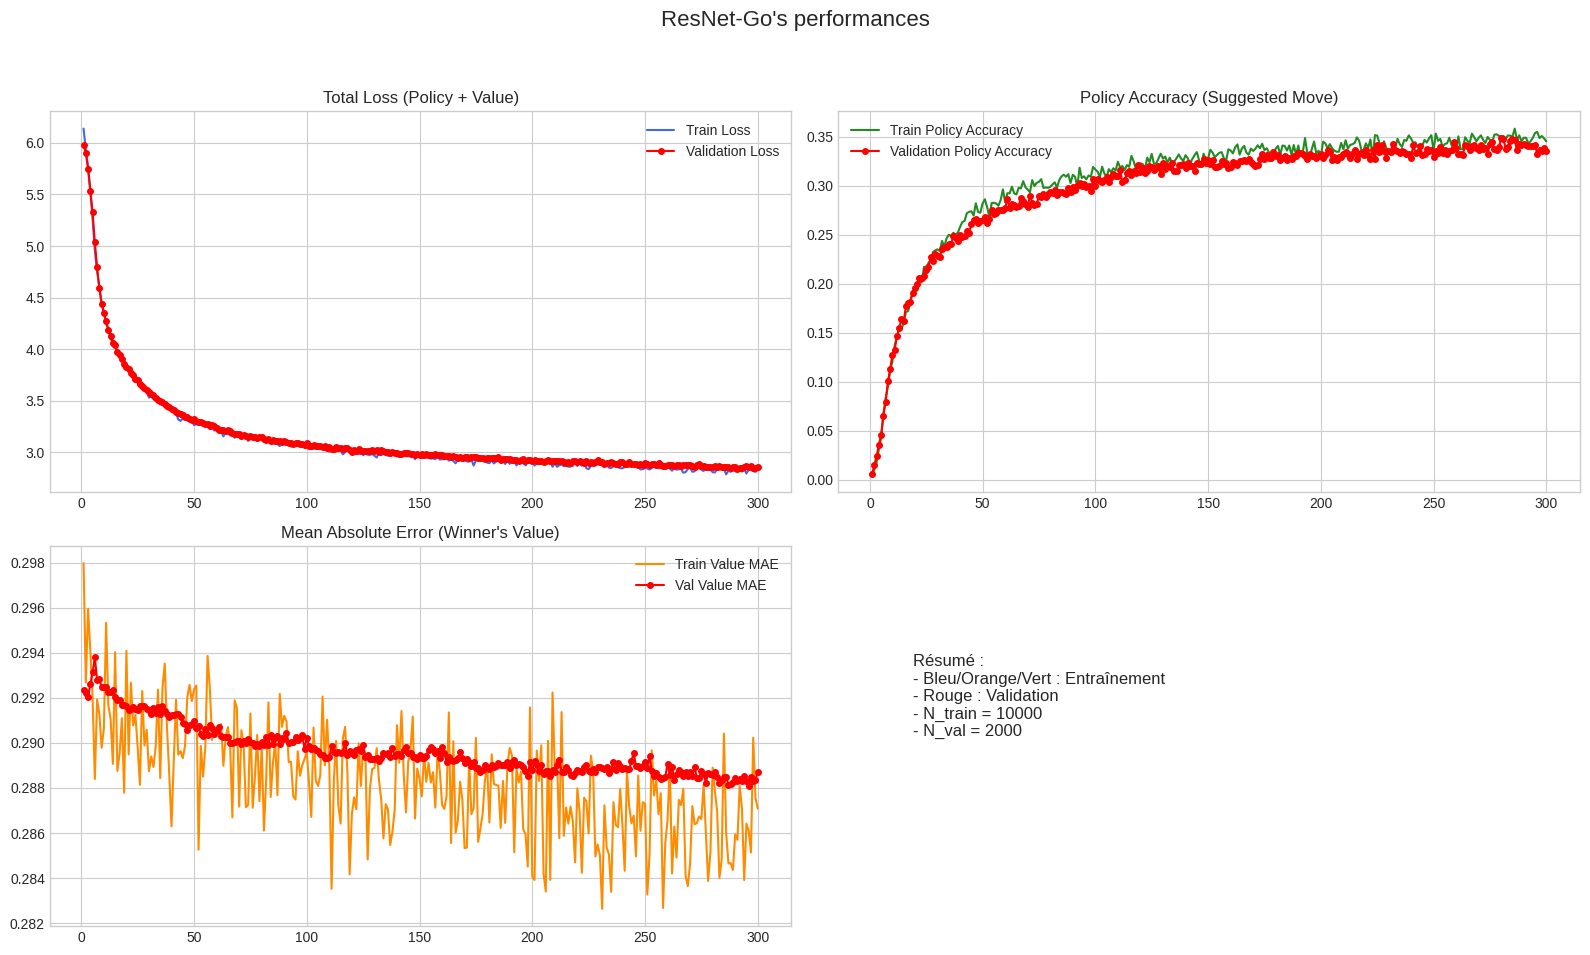

In [14]:
tf.keras.backend.clear_session(free_memory=True)

# --- Paramètres ---
planes, moves, N, epochs, batch, filters = 31, 361, 10000, 300, 128, 32
N_val = 2000

# --- Préparation des données ---
input_data = np.zeros((N, 19, 19, planes), dtype='float32')
policy = np.zeros((N, moves), dtype='float32')
value = np.zeros((N,), dtype='float32')
end = np.zeros((N, 19, 19, 2), dtype='float32')
groups = np.zeros((N, 19, 19, 1), dtype='float32')

val_input = np.zeros((N_val, 19, 19, planes), dtype='float32')
val_policy = np.zeros((N_val, moves), dtype='float32')
val_val = np.zeros((N_val,), dtype='float32')
val_end = np.zeros((N_val, 19, 19, 2), dtype='float32')

print("Chargement du set de validation séparé...")
golois.getValidation(val_input, val_policy, val_val, val_end)

# --- Architecture ---
model = create_resnet_for_go_model(planes, filters, num_blocks=3)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss={'policy': losses.CategoricalCrossentropy(), 'value': 'mse'},
              metrics={'policy': 'categorical_accuracy', 'value': 'mae'})

# --- Dictionnaire pour l'historique ---
history_data = {
    'train_loss': [], 'val_loss': [],
    'train_pol_acc': [], 'val_pol_acc': [],
    'train_val_mae': [], 'val_val_mae': [],
    'val_epochs': []
}

# --- Boucle d'entraînement ---
for i in range(1, epochs + 1):
    print(f'Epoch {i}/{epochs}')
    golois.getBatch(input_data, policy, value, end, groups, i * N)

    h = model.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)

    # Sauvegarde des métriques d'entraînement
    history_data['train_loss'].append(h.history['loss'][0])
    history_data['train_pol_acc'].append(h.history['policy_categorical_accuracy'][0])
    history_data['train_val_mae'].append(h.history['value_mae'][0])

    if i % 5 == 0: gc.collect()

    # Validation périodique
    val_res = model.evaluate(val_input, [val_policy, val_val], verbose=0, batch_size=batch)
    print(val_res)
    history_data['val_loss'].append(val_res[0])
    history_data['val_pol_acc'].append(val_res[3]) # Index 3 = policy_acc
    history_data['val_val_mae'].append(val_res[4]) # Index 4 = value_mae (total_loss, pol_loss, val_loss, pol_acc, val_mae)
    history_data['val_epochs'].append(i)

# --- Enregistrement des métriques ---
with open(histo_dir / "resNetGO.json", "w") as json_file:
  json.dump(history_data, json_file)

# --- Visualisation Grille 2x2 ---
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('ResNet-Go\'s performances', fontsize=16)

# 1. Total Loss
axs[0, 0].plot(range(1, epochs + 1), history_data['train_loss'], color='royalblue', label='Train Loss')
axs[0, 0].plot(history_data['val_epochs'], history_data['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Total Loss (Policy + Value)')
axs[0, 0].legend()

# 2. Policy Accuracy
axs[0, 1].plot(range(1, epochs + 1), history_data['train_pol_acc'], color='forestgreen', label='Train Policy Accuracy')
axs[0, 1].plot(history_data['val_epochs'], history_data['val_pol_acc'], label='Validation Policy Accuracy')
axs[0, 1].set_title('Policy Accuracy (Suggested Move)')
axs[0, 1].legend()

# 3. Value MAE
axs[1, 0].plot(range(1, epochs + 1), history_data['train_val_mae'], color='darkorange', label='Train Value MAE')
axs[1, 0].plot(history_data['val_epochs'], history_data['val_val_mae'], label='Validation Value MAE')
axs[1, 0].set_title('Mean Absolute Error (Winner\'s Value)')
axs[1, 0].legend()

# 4. Nettoyage de la 4ème case (ou on peut mettre un zoom sur la fin)
axs[1, 1].axis('off')
axs[1, 1].text(0.1, 0.5, "Résumé :\n- Bleu/Orange/Vert : Entraînement\n- Rouge : Validation\n- N_train = 10000\n- N_val = 2000", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
# --- Enregistrement des graphiques ---
resnet_figures_dir = figures_dir / "ResNetGO"
resnet_figures_dir.mkdir(exist_ok=True, parents=True)

# 1. Total Loss
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['train_loss'], color='royalblue', label='Train Loss')
plt.plot(history_data['val_epochs'], history_data['val_loss'], label='Validation Loss')
plt.title('Total Loss (Policy + Value)')
plt.legend()
plt.savefig(resnet_figures_dir / "total_loss.png")
plt.clf()

# 2. Policy Accuracy
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['train_pol_acc'], color='forestgreen', label='Train Policy Accuracy')
plt.plot(history_data['val_epochs'], history_data['val_pol_acc'], label='Validation Policy Accuracy')
plt.title('Policy Accuracy (Suggested Move)')
plt.legend()
plt.savefig(resnet_figures_dir / "policy_accuracy.png")
plt.clf()

# 3. Value MAE
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['train_val_mae'], color='darkorange', label='Train Value MAE')
plt.plot(history_data['val_epochs'], history_data['val_val_mae'], label='Validation Value MAE')
plt.title('Mean Absolute Error (Winner\'s Value)')
plt.legend()
plt.savefig(resnet_figures_dir / "value_mae.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [20]:
# --- Enregistrement du modèle ---
model.save(model_dir / "ResNetGO.h5")
model.save(model_dir / "ResNetGO.keras")

### reseaux residuels + attention en sortie (SE-post-block) avec cosine annealing


In [23]:
# ===================== #
# ARCHITECTURE          #
# ===================== #
def create_resnet_SE_CosA_for_go_model(planes, filters, num_blocks, name="ResNetSelfAttCosAnnealingGO"):
  """Création d'un modèle résiduel avec bloc self-attention et cosine annealing comme scheduler de taux d'apprentissage à deux têtes : une pour la politique et une pour la valeur"""
  # --- Input ---
  input_layer = keras.Input(shape=(19, 19, planes), name='board')

  # --- Conv ---
  x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input_layer)

  # --- Residual Blocks ---
  for i in range(num_blocks):
      ident = x
      x = layers.Conv2D(filters, 3, padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.ReLU()(x)
      x = layers.Conv2D(filters, 3, padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.add([ident, x])
      x = layers.ReLU()(x)

  # --- Squeeze and Excitation block ---
  se = layers.GlobalAveragePooling2D()(x)
  se = layers.Dense(filters // 4, activation='relu')(se)
  se = layers.Dense(filters, activation='sigmoid')(se)
  se = layers.Reshape((1, 1, filters))(se)
  x = layers.Multiply()([x, se])

  # --- Policy Head ---
  policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(x)
  policy_head = layers.Flatten()(policy_head)
  policy_head = layers.Activation('softmax', name='policy')(policy_head)

  # --- Value head ---
  value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(x)
  value_head = layers.Flatten()(value_head)
  value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
  value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

  return keras.Model(inputs=input_layer, outputs=[policy_head, value_head], name=name)


# --- Classe Learning Rate Schedule (Cosine Annealing + Warmup) ---
class CustomScheduleCA(LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, alpha=0.0, name='CosineDecay', warmup_steps=0):
        super(CustomScheduleCA, self).__init__()
        self.initial_learning_rate = tf.cast(initial_learning_rate, tf.float32)
        self.decay_steps = tf.cast(decay_steps, tf.float32)
        self.alpha = tf.cast(alpha, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.name = name
        self.cosine_decay_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=self.initial_learning_rate,
            decay_steps=self.decay_steps, alpha=self.alpha, name=self.name)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_lr = self.initial_learning_rate * (step / self.warmup_steps)
        decay_lr = self.cosine_decay_schedule(step - self.warmup_steps)
        return tf.cond(tf.math.less(step, self.warmup_steps), lambda: warmup_lr, lambda: decay_lr)

    def get_config(self):
        return {'initial_learning_rate': float(self.initial_learning_rate.numpy()), 'decay_steps': int(self.decay_steps.numpy()), 'alpha': float(self.alpha.numpy()), 'name': self.name, 'warmup_steps': int(self.warmup_steps.numpy())}

Chargement du set de validation séparé...
Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 6.1367 - policy_categorical_accuracy: 0.0033 - policy_loss: 5.9960 - value_loss: 0.1314 - value_mae: 0.3055
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.7353 - policy_categorical_accuracy: 0.0202 - policy_loss: 5.6007 - value_loss: 0.1254 - value_mae: 0.2987
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.8459 - policy_categorical_accuracy: 0.0694 - policy_loss: 4.7148 - value_loss: 0.1224 - value_mae: 0.2956
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.2532 - policy_categorical_accuracy: 0.1279 - policy_loss: 4.1242 - value_loss: 0.1208 - value_mae: 0.2925
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.9446 - policy_categorical_accuracy: 0.1749 - policy_loss: 3.8183 - value_loss: 0.1187 - value_mae: 0.2900
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.6938 - policy_categorical_accuracy: 0.2149 - policy_los

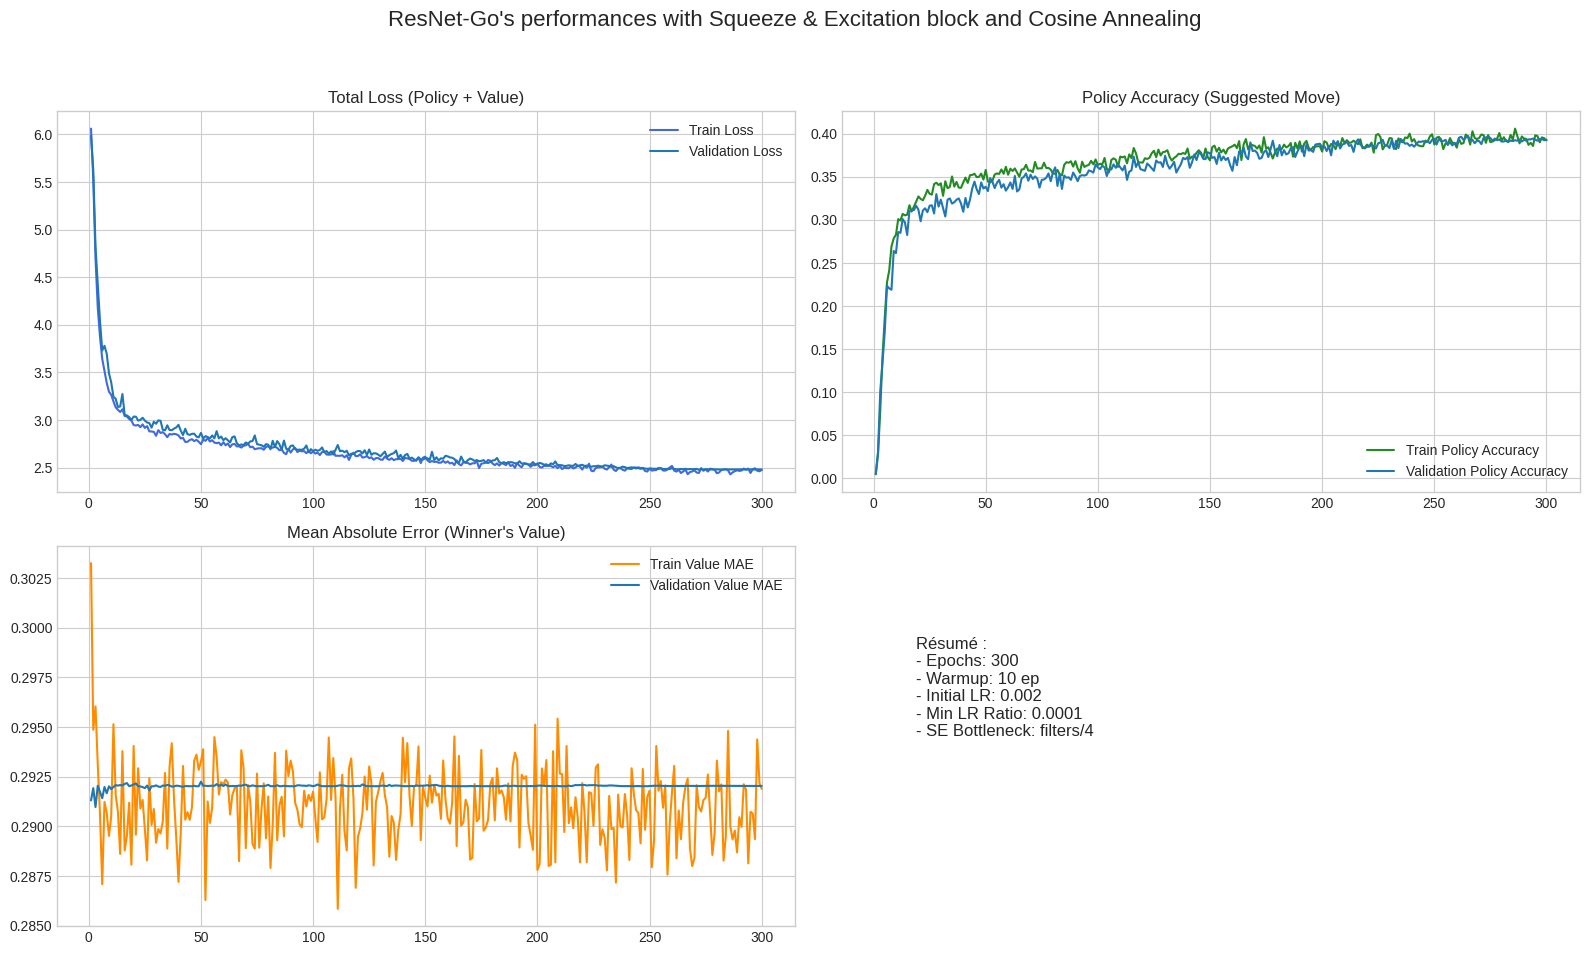

In [24]:
tf.keras.backend.clear_session(free_memory=True)

# --- Paramètres ---
planes, moves, N, epochs, batch, filters = 31, 361, 10000, 300, 128, 32
N_val = 2000

# --- Séparation des données (Allocation Mémoire) ---
input_data = np.zeros((N, 19, 19, planes), dtype='float32')
policy = np.zeros((N, moves), dtype='float32')
value = np.zeros((N,), dtype='float32')
end = np.zeros((N, 19, 19, 2), dtype='float32')
groups = np.zeros((N, 19, 19, 1), dtype='float32')

val_input = np.zeros((N_val, 19, 19, planes), dtype='float32')
val_policy = np.zeros((N_val, moves), dtype='float32')
val_val = np.zeros((N_val,), dtype='float32')
val_end = np.zeros((N_val, 19, 19, 2), dtype='float32')

print("Chargement du set de validation séparé...")
golois.getValidation(val_input, val_policy, val_val, val_end)

# --- Architecture ---
model = create_resnet_SE_CosA_for_go_model(planes, filters, 4)

# --- Compilation avec Schedule ---
steps_per_epoch = N // batch
lr_schedule = CustomScheduleCA(initial_learning_rate=0.002, decay_steps=steps_per_epoch*epochs, alpha=0.0001, warmup_steps=steps_per_epoch*10)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss={'policy': 'categorical_crossentropy', 'value': 'mse'},
              metrics={'policy': 'categorical_accuracy', 'value': 'mae'})

# --- Historique pour Visualisation ---
history_data = {
    't_loss': [], 'v_loss': [],
    't_pol_acc': [], 'v_pol_acc': [],
    't_val_mae': [], 'v_val_mae': [],
    'v_epochs': []
}

# --- Boucle d'entraînement ---
for i in range(1, epochs + 1):
    print(f'Epoch {i}/{epochs}')
    golois.getBatch(input_data, policy, value, end, groups, i * N)

    h = model.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)

    history_data['t_loss'].append(h.history['loss'][0])
    history_data['t_pol_acc'].append(h.history['policy_categorical_accuracy'][0])
    history_data['t_val_mae'].append(h.history['value_mae'][0])

    if i % 5 == 0: gc.collect()

    # --- Données de validation ---
    val_res = model.evaluate(val_input, [val_policy, val_val], verbose=0, batch_size=batch)
    history_data['v_loss'].append(val_res[0])
    history_data['v_pol_acc'].append(val_res[3])
    history_data['v_val_mae'].append(val_res[4])
    history_data['v_epochs'].append(i)

# --- Enregistrement des métriques ---
with open(histo_dir / "resNet_SE_CA_GO.json", "w") as json_file:
  json.dump(history_data, json_file)

# --- Visualisation Grille 2x2 ---
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('ResNet-Go\'s performances with Squeeze & Excitation block and Cosine Annealing', fontsize=16)

# 1. Total Loss
axs[0, 0].plot(range(1, epochs + 1), history_data['t_loss'], color='royalblue', label='Train Loss')
axs[0, 0].plot(history_data['v_epochs'], history_data['v_loss'], label='Validation Loss')
axs[0, 0].set_title('Total Loss (Policy + Value)')
axs[0, 0].legend()

# 2. Policy Accuracy
axs[0, 1].plot(range(1, epochs + 1), history_data['t_pol_acc'], color='forestgreen', label='Train Policy Accuracy')
axs[0, 1].plot(history_data['v_epochs'], history_data['v_pol_acc'], label='Validation Policy Accuracy')
axs[0, 1].set_title('Policy Accuracy (Suggested Move)')
axs[0, 1].legend()

# 3. Value MAE
axs[1, 0].plot(range(1, epochs + 1), history_data['t_val_mae'], color='darkorange', label='Train Value MAE')
axs[1, 0].plot(history_data['v_epochs'], history_data['v_val_mae'], label='Validation Value MAE')
axs[1, 0].set_title('Mean Absolute Error (Winner\'s Value)')
axs[1, 0].legend()

# 4. Nettoyage de la 4ème case (ou on peut mettre un zoom sur la fin)
axs[1, 1].axis('off')
axs[1, 1].text(0.1, 0.5, "Résumé :\n- Epochs: 300\n- Warmup: 10 ep\n- Initial LR: 0.002\n- Min LR Ratio: 0.0001\n- SE Bottleneck: filters/4", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [25]:
# --- Enregistrement des graphiques ---
resnetSECA_figures_dir = figures_dir / "ResNet-SE-CA-Go"
resnetSECA_figures_dir.mkdir(exist_ok=True, parents=True)

# 1. Total Loss
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['t_loss'], color='royalblue', label='Train Loss')
plt.plot(history_data['v_epochs'], history_data['v_loss'], label='Validation Loss')
plt.title('Total Loss (Policy + Value)')
plt.legend()
plt.savefig(resnetSECA_figures_dir / "total_loss.png")
plt.clf()

# 2. Policy Accuracy
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['t_pol_acc'], color='forestgreen', label='Train Policy Accuracy')
plt.plot(history_data['v_epochs'], history_data['v_pol_acc'], label='Validation Policy Accuracy')
plt.title('Policy Accuracy (Suggested Move)')
plt.legend()
plt.savefig(resnetSECA_figures_dir / "policy_accuracy.png")
plt.clf()

# 3. Value MAE
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['t_val_mae'], color='darkorange', label='Train Value MAE')
plt.plot(history_data['v_epochs'], history_data['v_val_mae'], label='Validation Value MAE')
plt.title('Mean Absolute Error (Winner\'s Value)')
plt.legend()
plt.savefig(resnetSECA_figures_dir / "value_mae.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [26]:
# --- Enregistrement du modèle ---
model.save(model_dir / "ResNet-SE-CA-Go.h5")
model.save(model_dir / "ResNet-SE-CA-Go.keras")

### reseaux residuels + attention en sortie (SE-post-block) sans cosine annealing


Chargement du set de validation séparé...
Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - loss: 6.0887 - policy_categorical_accuracy: 0.0023 - policy_loss: 5.9269 - value_loss: 0.1525 - value_mae: 0.3178
--- Validation Epoch 1 : Loss 5.9873 | Acc 5.8579
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.9002 - policy_categorical_accuracy: 0.0132 - policy_loss: 5.7590 - value_loss: 0.1320 - value_mae: 0.3008
--- Validation Epoch 2 : Loss 5.8221 | Acc 5.6912
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.6486 - policy_categorical_accuracy: 0.0245 - policy_loss: 5.5091 - value_loss: 0.1303 - value_mae: 0.3015
--- Validation Epoch 3 : Loss 5.5163 | Acc 5.3842
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.2956 - policy_categorical_accuracy: 0.0418 - policy_loss: 5.1602 - value_loss: 0.1264 - value_mae: 0.2977
--- Validation Epoch 4 : Loss 5.1467 | Acc 5.0150
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4.9889 - policy_categoric

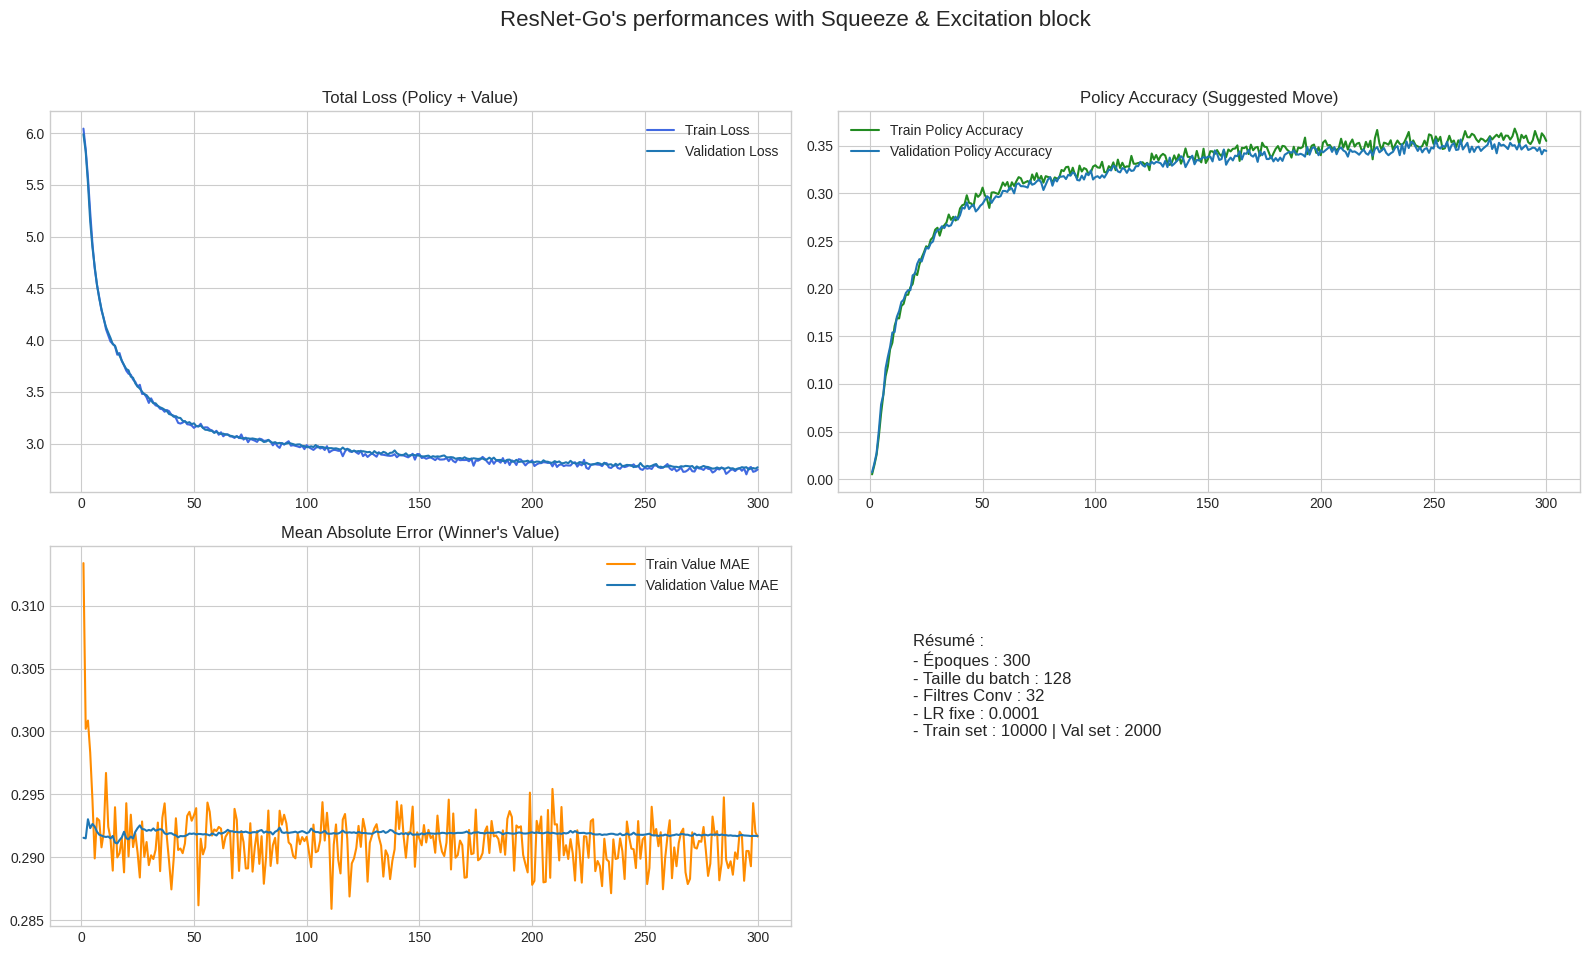

In [27]:
tf.keras.backend.clear_session(free_memory=True)

# --- Paramètres ---
planes, moves, N, epochs, batch, filters = 31, 361, 10000, 300, 128, 32
N_val = 2000  # Taille du set de validation distinct

# --- Préparation des données d'entraînement ---
input_data = np.zeros((N, 19, 19, planes), dtype='float32')
policy = np.zeros((N, moves), dtype='float32')
value = np.zeros((N,), dtype='float32')
end = np.zeros((N, 19, 19, 2), dtype='float32')
groups = np.zeros((N, 19, 19, 1), dtype='float32')

# --- Préparation des données de validation (SÉPARÉES) ---
val_input = np.zeros((N_val, 19, 19, planes), dtype='float32')
val_policy = np.zeros((N_val, moves), dtype='float32')
val_val = np.zeros((N_val,), dtype='float32')
val_end = np.zeros((N_val, 19, 19, 2), dtype='float32')

print("Chargement du set de validation séparé...")
golois.getValidation(val_input, val_policy, val_val, val_end)

# --- Création du modèle ---
model = create_resnet_SE_CosA_for_go_model(planes, filters, 4, name="ResNetSelfAttWithoutCosAnnealingGO")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss={'policy': 'categorical_crossentropy', 'value': 'mse'},
    metrics={'policy': 'categorical_accuracy', 'value': 'mae'}
)

# --- Historique pour toutes les métriques ---
history_data = {
    'train_loss': [], 'val_loss': [],
    'train_pol_acc': [], 'val_pol_acc': [],
    'train_val_mae': [], 'val_val_mae': [],
    'val_epochs': []
}

# --- Boucle d'entraînement ---
for i in range(1, epochs + 1):
    print(f'Epoch {i}/{epochs}')
    golois.getBatch(input_data, policy, value, end, groups, i * N)

    h = model.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)

    # Stockage entraînement
    history_data['train_loss'].append(h.history['loss'][0])
    history_data['train_pol_acc'].append(h.history['policy_categorical_accuracy'][0])
    history_data['train_val_mae'].append(h.history['value_mae'][0])

    if i % 5 == 0: gc.collect()

    # Validation périodique (tous les 20 pour un graphique plus détaillé)
    val_res = model.evaluate(val_input, [val_policy, val_val], verbose=0, batch_size=batch)
    history_data['val_loss'].append(val_res[0])
    history_data['val_pol_acc'].append(val_res[3]) # Index 1 : policy accuracy
    history_data['val_val_mae'].append(val_res[4]) # Index 4 : value MAE
    history_data['val_epochs'].append(i)

    print(f"--- Validation Epoch {i} : Loss {val_res[0]:.4f} | Acc {val_res[1]:.4f}")

# --- Enregistrement des métriques ---
with open(histo_dir / "resNet_SE_GO.json", "w") as json_file:
  json.dump(history_data, json_file)

# --- Visualisation Grille 2x2 ---
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('ResNet-Go\'s performances with Squeeze & Excitation block', fontsize=16)

# 1. Total Loss
axs[0, 0].plot(range(1, epochs + 1), history_data['train_loss'], color='royalblue', label='Train Loss')
axs[0, 0].plot(history_data['val_epochs'], history_data['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Total Loss (Policy + Value)')
axs[0, 0].legend()

# 2. Policy Accuracy
axs[0, 1].plot(range(1, epochs + 1), history_data['train_pol_acc'], color='forestgreen', label='Train Policy Accuracy')
axs[0, 1].plot(history_data['val_epochs'], history_data['val_pol_acc'], label='Validation Policy Accuracy')
axs[0, 1].set_title('Policy Accuracy (Suggested Move)')
axs[0, 1].legend()

# 3. Value MAE
axs[1, 0].plot(range(1, epochs + 1), history_data['train_val_mae'], color='darkorange', label='Train Value MAE')
axs[1, 0].plot(history_data['val_epochs'], history_data['val_val_mae'], label='Validation Value MAE')
axs[1, 0].set_title('Mean Absolute Error (Winner\'s Value)')
axs[1, 0].legend()

# 4. Nettoyage de la 4ème case (ou on peut mettre un zoom sur la fin)
axs[1, 1].axis('off')
axs[1, 1].text(0.1, 0.5, "Résumé :\n- Époques : 300\n- Taille du batch : 128\n- Filtres Conv : 32\n- LR fixe : 0.0001\n- Train set : 10000 | Val set : 2000", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [29]:
# --- Enregistrement des graphiques ---
resnetSE_figures_dir = figures_dir / "ResNet-SE-Go"
resnetSE_figures_dir.mkdir(exist_ok=True, parents=True)

# 1. Total Loss
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['train_loss'], color='royalblue', label='Train Loss')
plt.plot(history_data['val_epochs'], history_data['val_loss'], label='Validation Loss')
plt.title('Total Loss (Policy + Value)')
plt.legend()
plt.savefig(resnetSE_figures_dir / "total_loss.png")
plt.clf()

# 2. Policy Accuracy
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['train_pol_acc'], color='forestgreen', label='Train Policy Accuracy')
plt.plot(history_data['val_epochs'], history_data['val_pol_acc'], label='Validation Policy Accuracy')
plt.title('Policy Accuracy (Suggested Move)')
plt.legend()
plt.savefig(resnetSE_figures_dir / "policy_accuracy.png")
plt.clf()

# 3. Value MAE
plt.style.use('seaborn-v0_8-whitegrid') # Style propre pour les graphiques
plt.plot(range(1, epochs + 1), history_data['train_val_mae'], color='darkorange', label='Train Value MAE')
plt.plot(history_data['val_epochs'], history_data['val_val_mae'], label='Validation Value MAE')
plt.title('Mean Absolute Error (Winner\'s Value)')
plt.legend()
plt.savefig(resnetSE_figures_dir / "value_mae.png")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [30]:
# --- Enregistrement du modèle ---
model.save(model_dir / "ResNet-SE-Go.h5")
model.save(model_dir / "ResNet-SE-Go.keras")

### reseaux residuels + attention en sortie (SE-post-block) Avec distillation

In [33]:
tf.keras.backend.clear_session(free_memory=True)

# ============================================
# 1. ARCHITECTURE ET UTILS
# ============================================
def create_go_model(filters, num_blocks, name="go_model"):
    input_layer = keras.Input(shape=(19, 19, 31), name='board')
    x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input_layer)

    for i in range(num_blocks):
        ident = x
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.add([ident, x])
        x = layers.ReLU()(x)

    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // 4, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    x = layers.Multiply()([x, se])

    p_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False)(x)
    p_head = layers.Flatten()(p_head)
    p_head = layers.Activation('softmax', name='policy')(p_head)

    v_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias=False)(x)
    v_head = layers.Flatten()(v_head)
    v_head = layers.Dense(50, activation='relu')(v_head)
    v_head = layers.Dense(1, activation='sigmoid', name='value')(v_head)

    return keras.Model(inputs=input_layer, outputs=[p_head, v_head], name=name)

# ============================================
# 2. CLASSE DE DISTILLATION CORRIGÉE
# ============================================
class Distiller(keras.Model):
    def __init__(self, student, teacher, temperature=3.0, alpha=0.3):
        super(Distiller, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics, loss_weights):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.loss_weights = loss_weights
        self.policy_loss_fn = losses.CategoricalCrossentropy()
        self.value_loss_fn = losses.MeanSquaredError()
        self.distillation_loss_fn = losses.KLDivergence()

    def train_step(self, data):
        x, y = data
        y_policy, y_value = y

        t_pol, t_val = self.teacher(x, training=False)
        t_pol_soft = tf.nn.softmax(tf.math.log(t_pol + 1e-10) / self.temperature)

        with tf.GradientTape() as tape:
            s_pol, s_val = self.student(x, training=True)

            p_loss_hard = self.policy_loss_fn(y_policy, s_pol)
            v_loss_hard = self.value_loss_fn(y_value, s_val)

            s_pol_soft = tf.nn.softmax(tf.math.log(s_pol + 1e-10) / self.temperature)
            distill_p = self.distillation_loss_fn(t_pol_soft, s_pol_soft) * (self.temperature ** 2)
            distill_v = tf.reduce_mean(tf.square(t_val - s_val))

            total_p = (1 - self.alpha) * p_loss_hard + self.alpha * distill_p
            total_v = (1 - self.alpha) * v_loss_hard + self.alpha * distill_v

            total_loss = (self.loss_weights['policy'] * total_p + self.loss_weights['value'] * total_v)
            total_loss += sum(self.student.losses)

        grads = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # --- CORRECTION ICI : update_state AVANT result() ---
        for m in self.metrics:
            if 'policy' in m.name:
                m.update_state(y_policy, s_pol)
            elif 'value' in m.name:
                m.update_state(y_value, s_val)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": total_loss})
        return results

    def test_step(self, data):
        x, y = data
        y_policy, y_value = y
        preds = self.student(x, training=False)
        for m in self.metrics:
            if 'policy' in m.name: m.update_state(y_policy, preds[0])
            elif 'value' in m.name: m.update_state(y_value, preds[1])
        return {m.name: m.result() for m in self.metrics}

# ============================================
# 3. BOUCLE D'ENTRAÎNEMENT ET VISUALISATION
# ============================================
N, N_val, epochs_t, epochs_s, batch = 10000, 2000, 1, 300, 128
input_data = np.zeros((N, 19, 19, 31), dtype='float32')
policy = np.zeros((N, 361), dtype='float32')
value, end, groups = np.zeros((N,), dtype='float32'), np.zeros((N, 19, 19, 2), dtype='float32'), np.zeros((N, 19, 19, 1), dtype='float32')

val_in = np.zeros((N_val, 19, 19, 31), dtype='float32')
val_pol = np.zeros((N_val, 361), dtype='float32')
val_v = np.zeros((N_val,), dtype='float32')
val_e = np.zeros((N_val, 19, 19, 2), dtype='float32')

golois.getValidation(val_in, val_pol, val_v, val_e)

# --- Phase Teacher ---
teacher = create_go_model(64, 6, "teacher")
teacher.compile(optimizer='adam', loss={'policy': 'categorical_crossentropy', 'value': 'mse'},
                metrics={'policy': 'categorical_accuracy', 'value': 'mae'})

t_hist = {'loss': [], 'acc': [], 'val_acc': [], 'val_epochs': []}

for i in range(1, epochs_t + 1):
    golois.getBatch(input_data, policy, value, end, groups, i * N)
    h = teacher.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)
    t_hist['loss'].append(h.history['loss'][0])
    t_hist['acc'].append(h.history['policy_categorical_accuracy'][0])

    # Validation
    r = teacher.evaluate(val_in, [val_pol, val_v], verbose=0)
    print(r)
    t_hist['val_acc'].append(r[1])
    t_hist['val_epochs'].append(i)

# --- Phase Student ---
student = create_go_model(32, 4, "student")
distiller = Distiller(student, teacher, alpha=0.3)
distiller.compile(optimizer='adam', metrics={'policy': metrics.CategoricalAccuracy(name='policy_acc'), 'value': metrics.MeanAbsoluteError(name='value_mae')}, loss_weights={'policy': 1.0, 'value': 1.0})

s_hist = {'loss': [], 'acc': [], 'val_acc': [], 'val_epochs': []}

for i in range(1, epochs_s + 1):
    golois.getBatch(input_data, policy, value, end, groups, i * N)
    h = distiller.fit(input_data, [policy, value], epochs=1, batch_size=batch, verbose=1)

    # Correction de l'accès aux clés du dictionnaire history
    s_hist['loss'].append(h.history['loss'][0])
    s_hist['acc'].append(h.history['policy_acc'][0])

    # Validation
    r = distiller.evaluate(val_in, [val_pol, val_v], verbose=0)
    print(r)
    s_hist['val_acc'].append(r[0]) # r[0] car evaluate renvoie [policy_acc, value_mae]
    s_hist['val_epochs'].append(i)

# --- Visualisation ---

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(t_hist['loss'], label='Teacher Train', alpha=0.3)
axs[0].plot(s_hist['loss'], label='Student Distill', color='green')
axs[0].set_title('Pertes (Loss)'); axs[0].legend()

axs[1].plot(t_hist['val_epochs'], t_hist['val_acc'], 'b--o', label='Teacher Val')
axs[1].plot(s_hist['val_epochs'], s_hist['val_acc'], 'r-o', label='Student Val')
axs[1].set_title('Précision (Policy Accuracy)'); axs[1].legend()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - loss: 5.5456 - policy_categorical_accuracy: 0.0281 - policy_loss: 5.4132 - value_loss: 0.1320 - value_mae: 0.3043
[5.327397346496582, 5.206180572509766, 0.11888844519853592, 0.08399999886751175, 0.2920183539390564]


ValueError: Cannot get result() since the metric has not yet been built.